In [6]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

# Fetch MNIST data
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X, y = X / 255.0, y.astype(int)

In [7]:
def sample_class(X, y, num_train, num_val, num_test):
    X_train, y_train, X_val, y_val, X_test, y_test = [], [], [], [], [], []
    for label in np.unique(y):
        X_label = X[y == label]
        y_label = y[y == label]
        X_label, y_label = shuffle(X_label, y_label, random_state=42)

        X_train.append(X_label[:num_train])
        y_train.append(y_label[:num_train])
        X_val.append(X_label[num_train:num_train + num_val])
        y_val.append(y_label[num_train:num_train + num_val])
        X_test.append(X_label[num_train + num_val:])
        y_test.append(y_label[num_train + num_val:])

    return (np.concatenate(X_train), np.concatenate(y_train),
            np.concatenate(X_val), np.concatenate(y_val),
            np.concatenate(X_test), np.concatenate(y_test))

# Split data
X_train, y_train, X_val, y_val, X_test, y_test = sample_class(X, y, 300, 100, 300)

# Define C values for GridSearchCV
C_values = np.logspace(-3, 3, 10)

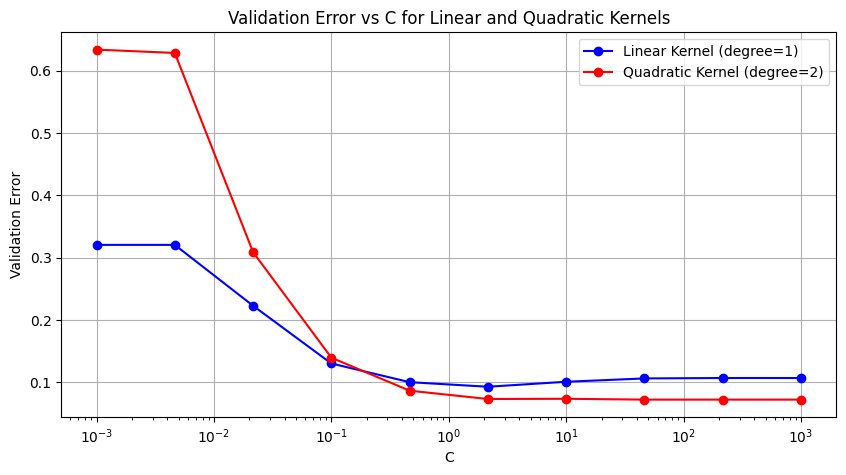

In [8]:
# Train and tune Linear SVM with poly kernel and degree=1
linear_svm = SVC(kernel='poly', degree=1)
linear_grid = GridSearchCV(linear_svm, {'C': C_values}, cv=5)
linear_grid.fit(X_train, y_train)
best_C_linear = linear_grid.best_params_['C']
val_error_linear = 1 - linear_grid.best_score_

# Train and tune Quadratic SVM with poly kernel and degree=2
quadratic_svm = SVC(kernel='poly', degree=2)
quadratic_grid = GridSearchCV(quadratic_svm, {'C': C_values}, cv=5)
quadratic_grid.fit(X_train, y_train)
best_C_quadratic = quadratic_grid.best_params_['C']
val_error_quadratic = 1 - quadratic_grid.best_score_

# Plot Linear and Quadratic SVM results in the same graph
plt.figure(figsize=(10, 5))
plt.plot(C_values, 1 - np.array(linear_grid.cv_results_['mean_test_score']), label='Linear Kernel (degree=1)', marker='o', color='blue')
plt.plot(C_values, 1 - np.array(quadratic_grid.cv_results_['mean_test_score']), label='Quadratic Kernel (degree=2)', marker='o', color='red')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Validation Error')
plt.legend()
plt.title('Validation Error vs C for Linear and Quadratic Kernels')
plt.grid(True)
plt.show()

In [9]:
# Retrain Linear SVM with best C on the entire training set
final_linear_svm = SVC(kernel='poly', degree=1, C=best_C_linear)
final_linear_svm.fit(np.concatenate([X_train, X_val]), np.concatenate([y_train, y_val]))
test_error_linear = 1 - final_linear_svm.score(X_test, y_test)

# Retrain Quadratic SVM with best C on the entire training set
final_quadratic_svm = SVC(kernel='poly', degree=2, C=best_C_quadratic)
final_quadratic_svm.fit(np.concatenate([X_train, X_val]), np.concatenate([y_train, y_val]))
test_error_quadratic = 1 - final_quadratic_svm.score(X_test, y_test)

# Print results for Linear and Quadratic kernels
print(f"Linear Kernel (degree=1): Best C = {best_C_linear}, Validation Error = {val_error_linear:.4f}, Test Error = {test_error_linear:.4f}")
print(f"Quadratic Kernel (degree=2): Best C = {best_C_quadratic}, Validation Error = {val_error_quadratic:.4f}, Test Error = {test_error_quadratic:.4f}")

Linear Kernel (degree=1): Best C = 2.154434690031882, Validation Error = 0.0927, Test Error = 0.0806
Quadratic Kernel (degree=2): Best C = 46.41588833612773, Validation Error = 0.0720, Test Error = 0.0540


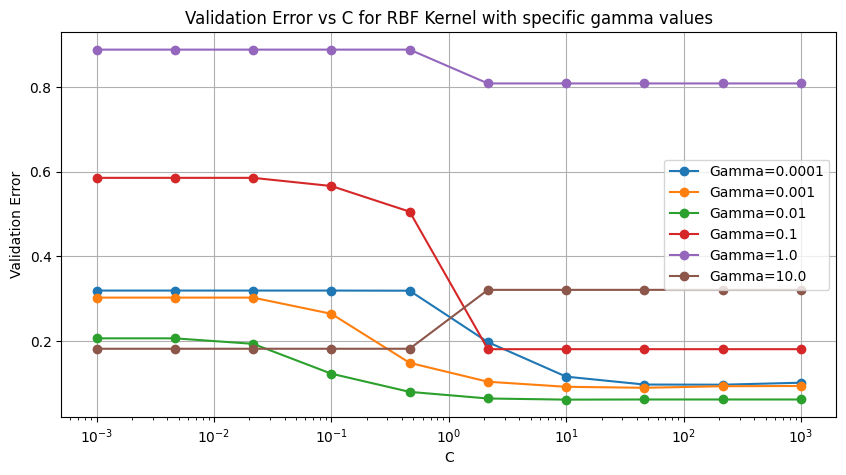

In [10]:
# Define specific gamma values for RBF kernel
gamma_values = [1e-4, 1e-3, 1e-2, 1e-1, 1e-0, 1e1]

# Create a parameter grid for RBF kernel
param_grid_rbf = {'C': C_values, 'gamma': gamma_values}

# Train and tune RBF SVM
rbf_svm = SVC(kernel='rbf')
rbf_grid = GridSearchCV(rbf_svm, param_grid_rbf, cv=5)
rbf_grid.fit(X_train, y_train)
best_params_rbf = rbf_grid.best_params_
best_C_rbf = best_params_rbf['C']
best_gamma_rbf = best_params_rbf['gamma']
val_error_rbf = 1 - rbf_grid.best_score_

# Plot RBF SVM results
plt.figure(figsize=(10, 5))
scores_matrix = rbf_grid.cv_results_['mean_test_score'].reshape(len(C_values), len(gamma_values))
for i, gamma in enumerate(gamma_values):
    plt.plot(C_values, 1 - scores_matrix[:, i], label=f'Gamma={gamma}', marker='o')

plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Validation Error')
plt.title('Validation Error vs C for RBF Kernel with specific gamma values')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# Retrain RBF SVM with best C and gamma on the entire training set
final_rbf_svm = SVC(kernel='rbf', C=best_C_rbf, gamma=best_gamma_rbf)
final_rbf_svm.fit(np.concatenate([X_train, X_val]), np.concatenate([y_train, y_val]))
test_error_rbf = 1 - final_rbf_svm.score(X_test, y_test)

# Print results for RBF kernel
print(f"RBF Kernel: Best C = {best_C_rbf}, Best Gamma = {best_gamma_rbf}, Validation Error = {val_error_rbf:.4f}, Test Error = {test_error_rbf:.4f}")

RBF Kernel: Best C = 10.0, Best Gamma = 0.01, Validation Error = 0.0610, Test Error = 0.0494
